In [1]:
import os
import pandas as pd
import numpy as np
from ultralytics import YOLO
from PIL import Image
from IPython.display import display
from sahi.utils.yolov8 import (
    download_yolov8s_model, download_yolov8s_seg_model
)

from sahi import AutoDetectionModel
from sahi.utils.cv import read_image
from sahi.utils.file import download_from_url
from sahi.predict import get_prediction, get_sliced_prediction, predict
from IPython.display import Image as IPImage
from scipy.ndimage import maximum_filter
import matplotlib.pyplot as plt
from pathlib import Path
from fastai.vision.all import *
from fastai.metrics import error_rate
import matplotlib.pyplot as plt
import numpy as np
import sahi
from sahi.slicing import slice_image
from sahi.utils.file import save_json
from sahi import DetectionModel
from sahi.utils.cv import read_image
from sahi.predict import get_sliced_prediction
from sahi.models.torchvision import TorchVisionDetectionModel
import torch
import torchvision.models as models

WARNING ⚠️ Python>=3.10 is required, but Python==3.9.7 is currently installed 


In [2]:
test = "./test_images"

In [3]:
def get_mask_path(image_path):
    return str(image_path).replace(images_folder, masks_folder).replace("/images", "").replace(".jpg", ".png")

In [4]:
learn = load_learner("./datasets/resnet50-export.pkl")

In [5]:
image_tuples = []
for subdirectory in os.listdir(test):
    image_tuples.append((subdirectory, []))
    sub_path = os.path.join(test, subdirectory)
    for date in os.listdir(sub_path):
        date_path = os.path.join(sub_path, date)
        for file in os.listdir(date_path):
            if file.endswith(".png"):
                file_path = os.path.join(date_path, file)
                image_tuples[-1][1].append(file_path)

In [6]:
predictions = []
for i in range(len(image_tuples)):
    image_tuple = image_tuples[i]
    predictions.append((image_tuple[0], []))
    result = None
    for j in range(len(image_tuple[1])):
        image_path = image_tuple[1][j]
        image = PILImage.create(image_path)
        pred_mask, pred_idx, outputs = learn.predict(image)
        result = (pred_mask, pred_idx, outputs)
        predictions[-1][1].append(result)
    break

In [7]:
import pickle
with open("predictions.pkl", "wb") as f:
    pickle.dump(predictions, f)

In [24]:
predictions[0][1][1][2][1]

TensorBase([[7.3058e-04, 4.5784e-04, 1.1633e-04,  ..., 6.9462e-04, 1.4346e-02, 2.3215e-02],
            [4.8208e-04, 3.0436e-04, 6.1070e-05,  ..., 6.4700e-04, 1.6012e-02, 2.3196e-02],
            [1.8115e-04, 1.0513e-04, 4.8329e-05,  ..., 7.6598e-05, 8.9340e-03, 1.1784e-02],
            ...,
            [3.2109e-03, 3.7449e-03, 6.8888e-04,  ..., 1.0959e-03, 2.4252e-02, 2.3306e-02],
            [3.9555e-02, 7.1887e-02, 4.0836e-02,  ..., 2.2118e-02, 8.0706e-02, 7.1163e-02],
            [6.1900e-02, 7.1394e-02, 6.7271e-02,  ..., 3.4167e-02, 1.0269e-01, 9.8819e-02]])

In [26]:
confidence_predictions = []
for i in range(len(predictions[0][1])):
    mask = predictions[0][1][i][2][1] > 0.8
    confidence_predictions.append(mask)

In [27]:
stacked = np.stack([mask for mask in confidence_predictions], axis=0)

In [29]:
true_counts = np.sum(stacked, axis=0)

In [36]:
result = true_counts > 1
result_0 = true_counts > 0

In [ ]:
# class_1_probs = outputs[1]
# confident_mask_8 = class_1_probs > 0.8
# if result is None:
#     result = confident_mask_8
# else:
#     result = np.logical_or(result, confident_mask_8)
# predictions.append(result)

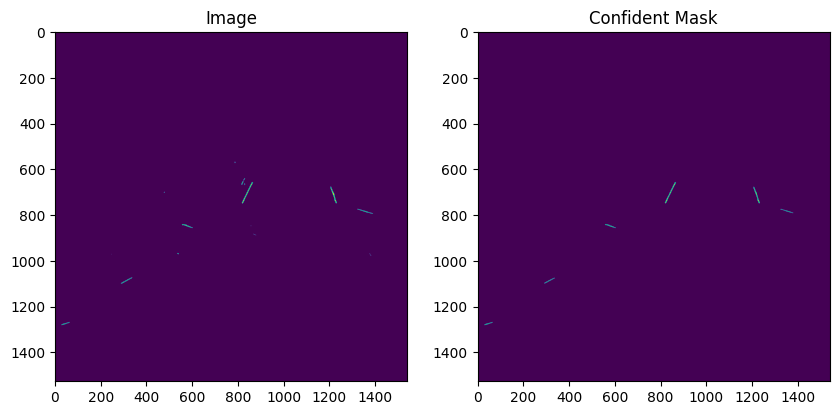

In [37]:
plt.figure(figsize=(10, 5))

# Display the first image
plt.subplot(1, 2, 1)
plt.imshow(result_0)
plt.title('Image')

# Display the second image
plt.subplot(1, 2, 2)
plt.imshow(result)
plt.title('Confident Mask')

plt.show()

In [ ]:
buffer_size = 20
filter_size = 2 * buffer_size + 1
buffered_result = maximum_filter(mask, size=filter_size)
for i in range(1, len(result.object_prediction_list)):
            mask = result.object_prediction_list[i].mask.bool_mask
            buffered_mask = maximum_filter(mask, size=filter_size)
            buffered_result = np.logical_or(buffered_result, buffered_mask)
buffered_results.append(buffered_result)
stacked_results = np.stack(buffered_results)
final_result = np.any(stacked_results, axis=0)
predictions.append((final_result, batch[0][1]))

In [ ]:
IPImage("./test-data-masked/prediction_visual.png")

In [ ]:
for prediction, _ in predictions:
    plt.imshow(prediction)
    plt.show()

In [22]:
sample = pd.read_csv("./SampleSubmission.csv")

In [ ]:
sample.info()

In [9]:
for i in range(len(predictions)):
    prediction, id = predictions[i]
    cleaned_id = "Tileaoi_" + id[2:].replace(".shp", "")
    predictions[i] = (prediction, cleaned_id)

In [24]:
pred_map = {key: value for value, key in predictions}

In [25]:
sample["prefix"] = sample["tile_row_column"].str[:13]

In [26]:
sample["label"] = sample["prefix"].map(pred_map)

In [27]:
sample["x"] = sample["tile_row_column"].str[14:].str.split("_").str[0].astype(int)
sample["y"] = sample["tile_row_column"].str[14:].str.split("_").str[1].astype(int)

In [28]:
sample['label'] = sample.apply(lambda row: row['label'][row['y'], row['x']], axis=1)

In [29]:
sample = sample.drop(columns=["prefix", "x", "y"])

In [30]:
sample["label"] = sample["label"].astype(int)

In [31]:
sample = sample.sort_values(by="label", ascending=False)

In [32]:
sample = sample.head(200000)

In [ ]:
count_of_ones = (sample['label'] == 1).sum()
print(f"Count of ones: {count_of_ones}")

In [34]:
sample = sample[sample['label'] != 0]

In [35]:
sample.to_csv("submission.csv", index=False)